# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import time
from matplotlib.pyplot import hist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1 import make_axes_locatable

# produce visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [4]:
azdias.shape

(891221, 85)

In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,RELAT_AB,person,ordinal,[-1]
freq,1,43,49,26


In [7]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
feat_info.shape

(85, 4)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Identify missing or unknown data values and convert them to NaNs.

feat_info_values = feat_info.values

for i in range(feat_info_values.shape[0]):
    
    attribute = feat_info_values[i,0]
    missing_or_unknown = feat_info_values[i,3]
    
    if 'XX' in missing_or_unknown:
        missing_or_unknown = missing_or_unknown.replace("XX", "'XX'")
    elif 'X' in missing_or_unknown:
        missing_or_unknown = missing_or_unknown.replace("X", "'X'")
        
    m_or_unk_list = ast.literal_eval(missing_or_unknown)
    mask = azdias[attribute].isin(m_or_unk_list)
    azdias.loc[mask, attribute] = azdias.loc[mask, attribute].apply(lambda x: np.nan)


In [10]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,205378.000000,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,1.743410,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,0.674312,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


In [11]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Perform an assessment of how much missing data there is, in each column of the
# dataset.
nan_count_per_col = azdias.isnull().sum(axis = 0)

print(nan_count_per_col)

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [13]:
# Show number of columns with null value
nan_count_per_col_val = nan_count_per_col.values
count_null = 0
for i in range(len(nan_count_per_col_val)):
    if nan_count_per_col_val[i] != 0:
        count_null += 1
print("Number of columns with null: ", count_null)

Number of columns with null:  61


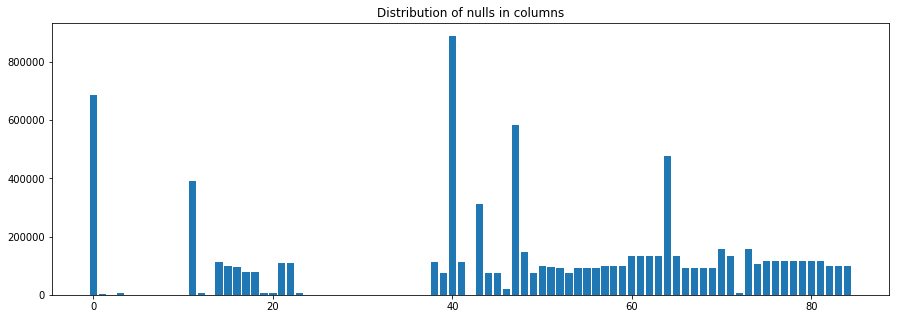

In [14]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(15,5))
x = np.arange(len(nan_count_per_col_val))
plt.bar(x, nan_count_per_col_val)
plt.title('Distribution of nulls in columns')
plt.show()

In [15]:
# choose outlier columns based on graphical information
def show_cols_to_drop(df, nan_count_per_col_val, max_num):
    col_list_drop = []
    count_drop = 0
    for i in range(len(nan_count_per_col_val)):
        if nan_count_per_col_val[i] >= max_num:
            col_list_drop.append(i)
            count_drop += 1
    print("Number of columns to drop: ", count_drop)
    col_list_drop = list(df.columns[col_list_drop])
    return col_list_drop

col_list_drop_vis = show_cols_to_drop(azdias, nan_count_per_col_val, 200000)

Number of columns to drop:  6


In [16]:
# Print columns to drop
print(col_list_drop_vis)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [17]:
# using interquartiles to detect outliers
def get_iqr_upper_bound(null_count_per_row_val):
    null_count_per_row_val_sort = np.array(null_count_per_row_val)
    null_count_per_row_val_sort.sort()
    q1, q3= np.percentile(null_count_per_row_val_sort,[25,75])
    iqr = q3 - q1
    print("q1: ", q1, " q3: ", q3, " iqr: ", iqr)
    upper_bound = q3 + (1.5 * iqr) 

    outlier_list_iqr = []

    for x in null_count_per_row_val: 
        # detect top outliers, i.e. one-sided detection
        if x > upper_bound:
            outlier_list_iqr.append(x)
    print("Number of outliers: ", len(outlier_list_iqr))
    print("upper_bound: ", upper_bound)
    if outlier_list_iqr:
        print("min outlier value: ", min(outlier_list_iqr))
    
    return upper_bound
nan_count_per_col_val_sort = np.array(nan_count_per_col_val)    
_ = get_iqr_upper_bound(nan_count_per_col_val_sort)

q1:  0.0  q3:  116515.0  iqr:  116515.0
Number of outliers:  6
upper_bound:  291287.5
min outlier value:  310267


In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_init = pd.DataFrame(data = azdias)
max_nan = 200000
azdias = azdias.drop(azdias.columns[azdias.apply(lambda col: col.isnull().sum() > max_nan)], axis=1)

In [19]:
azdias.shape

(891221, 79)

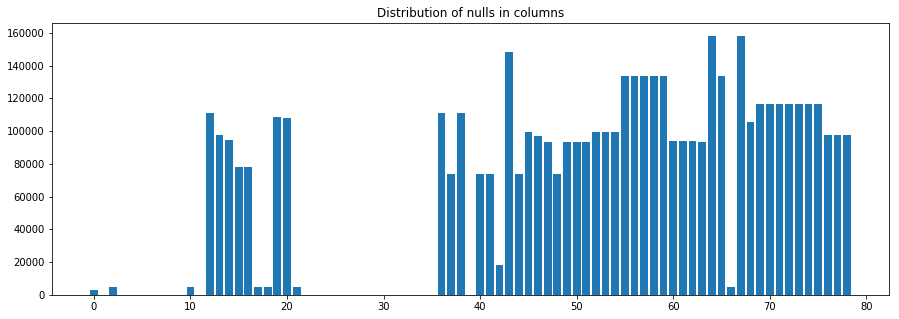

In [20]:
# Show distribution of nulls in columns
nan_count_per_col_2 = azdias.isnull().sum(axis = 0)

plt.figure(figsize=(15,5))
x = np.arange(len(nan_count_per_col_2.values))
plt.bar(x, nan_count_per_col_2.values)
plt.title('Distribution of nulls in columns')
plt.show()

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

There were 85 columns in the dataset, 24 columns did not have any missing value, the column with the highest number of missing values was the TITEL_KZ column with 889061 null values. Six columns were identified as outlying columns, because the number null values in each outlying column was signifcantly greater than the number in the other columns. The outlying columns have been removed from the dataset and they are: 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', and 'KBA05_BAUMAX'.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [21]:
# How much data is missing in each row of the dataset?
null_count_per_row = azdias.isnull().sum(axis=1)

In [22]:
print(null_count_per_row[:10])

0    43
1     0
2     0
3     7
4     0
5     0
6     0
7     0
8     0
9     0
dtype: int64


In [23]:
# Number of rows with nulls
null_count_per_row_val = null_count_per_row.values
count_null = 0
for i in range(len(null_count_per_row_val)):
    if null_count_per_row_val[i] > 0:
        count_null += 1
print("Number of rows with null: ", count_null)

Number of rows with null:  268012


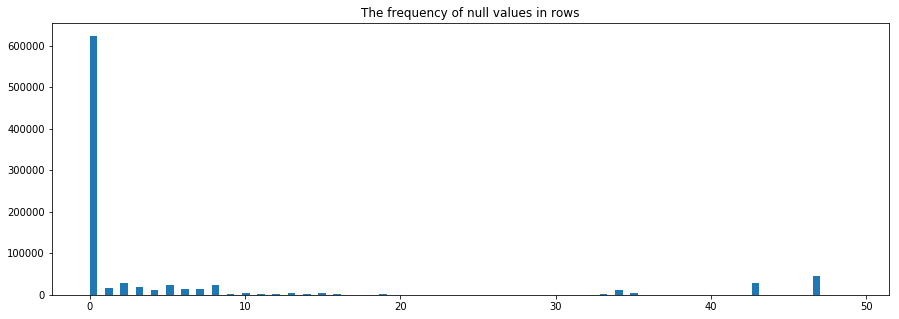

In [24]:
plt.figure(figsize=(15,5))
plt.hist(null_count_per_row_val, bins=100)
plt.title('The frequency of null values in rows')
plt.show()

In [25]:
print("max number of nulls: ", max(null_count_per_row_val))

max number of nulls:  49


In [26]:
# using normal distribution to detect row outliers
max_z = 2
mean_null = np.mean(null_count_per_row_val)
std_null = np.std(null_count_per_row_val)
outlier_list = []

for x in null_count_per_row_val:
    z_score= (x - mean_null)/std_null 
    # eliminate top outliers, i.e. one-sided elimination
    if z_score > max_z:
        outlier_list.append(x)
print("Number of outliers: ", len(outlier_list))
print("min outlier: ", min(outlier_list))

Number of outliers:  92945
min outlier:  33


In [27]:
# using IQR to detect row outliers
upper_bound = get_iqr_upper_bound(null_count_per_row_val)

q1:  0.0  q3:  3.0  iqr:  3.0
Number of outliers:  144112
upper_bound:  7.5
min outlier value:  8


In [28]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
mask = null_count_per_row > upper_bound + 2.5     # increase threshold to 10
row_outliers = pd.DataFrame(data=azdias.loc[mask])

mask = null_count_per_row <= upper_bound + 2.5
azdias = azdias.loc[mask]

In [29]:
azdias.shape

(780153, 79)

In [30]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Pick 5 columns where the number of nulls is zero
nan_count_per_col_val = azdias.isnull().sum(axis = 0).values
list_idx = []
idx_counter = 0
for i in range(len(nan_count_per_col_val)):
    if nan_count_per_col_val[i] == 0:
        list_idx.append(i)
        idx_counter += 1
    if idx_counter == 5:
        break

# 5 columns with no missing values
col_name_list = azdias.columns[list_idx]
print(list(col_name_list))
azdias[col_name_list].describe()

['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER']


,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER
count,780153.000000,780153.000000,780153.000000,780153.000000,780153.000000
mean,1.521235,3.050657,2.711548,3.439027,2.838339
std,0.499549,1.378001,1.486898,1.376730,1.473251
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,2.000000,1.000000
50%,2.000000,3.000000,3.000000,4.000000,3.000000
75%,2.000000,4.000000,4.000000,5.000000,4.000000
max,2.000000,5.000000,5.000000,5.000000,5.000000


In [31]:
row_outliers[col_name_list].describe()

,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER
count,111068.000000,111068.000000,111068.000000,111068.000000,111068.000000
mean,1.528163,3.242203,3.590116,3.134746,4.402951
std,0.499208,0.795908,1.005289,0.795002,1.177010
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,3.000000,4.000000,3.000000,4.000000
50%,2.000000,3.000000,4.000000,3.000000,5.000000
75%,2.000000,3.000000,4.000000,3.000000,5.000000
max,2.000000,5.000000,5.000000,5.000000,5.000000


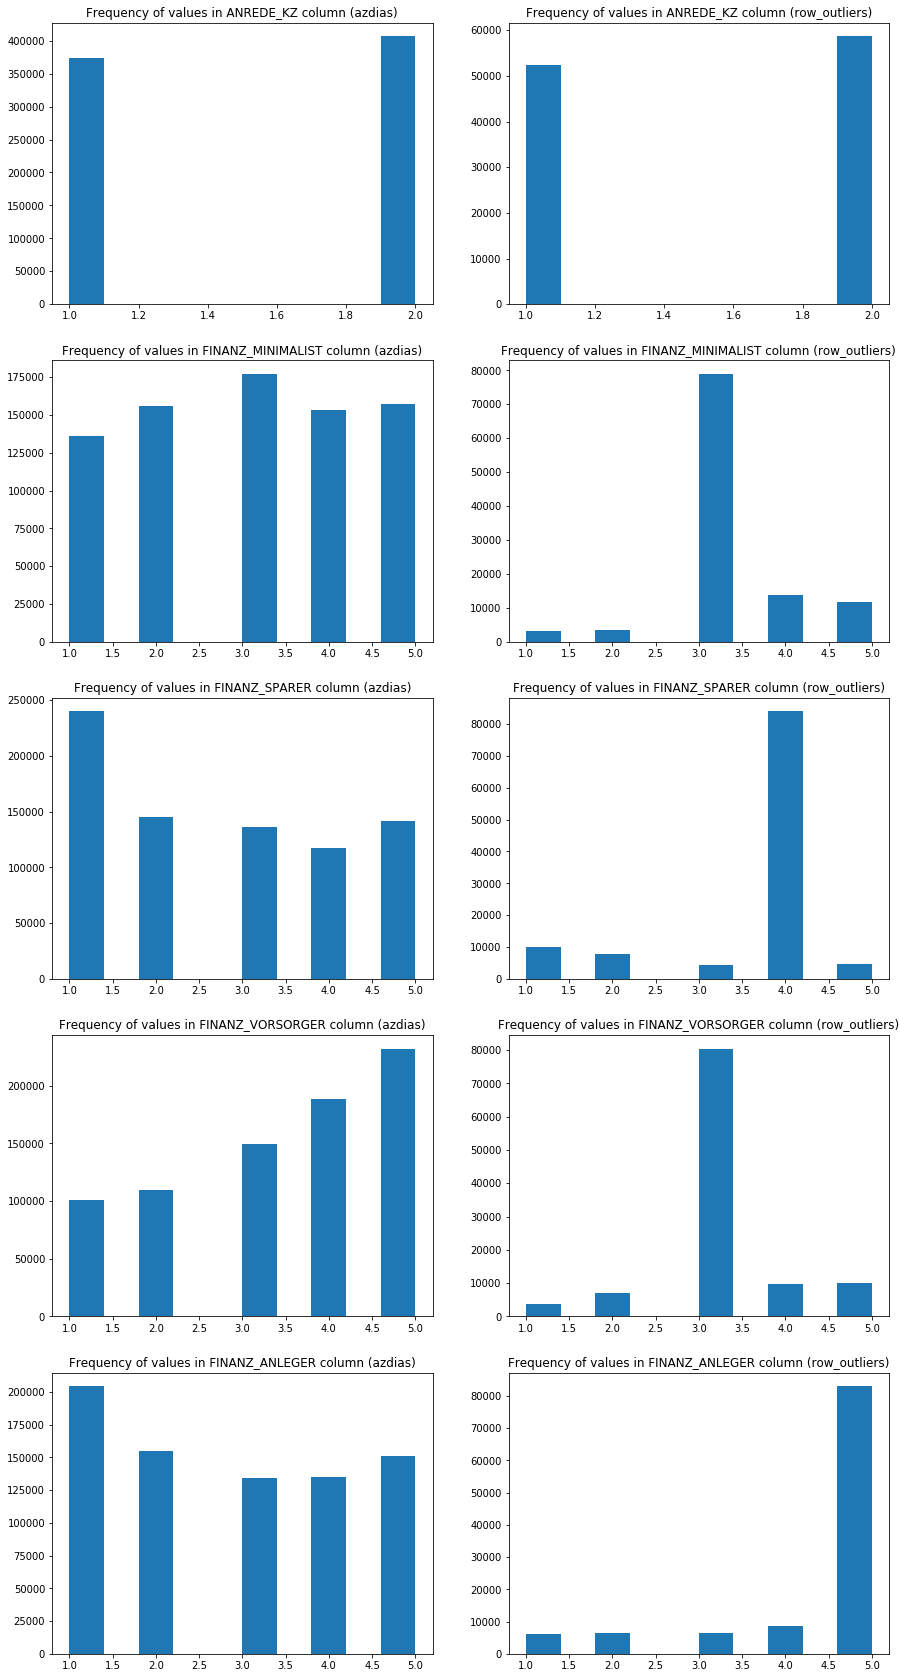

In [32]:
# Compare the distribution of column values
plt.figure(figsize=(15, 30))
j = 1
for i in range(len(col_name_list)):
    plt.subplot(5,2,j)
    col_values = azdias[col_name_list[i]].values
    plt.hist(col_values)
    plt.title('Frequency of values in '+col_name_list[i]+ ' column (azdias)')
    j += 1


    plt.subplot(5,2,j)
    col_values = row_outliers[col_name_list[i]].values
    plt.hist(col_values)
    plt.title('Frequency of values in '+col_name_list[i]+ ' column (row_outliers)')
    j += 1
plt.show()

## Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values qualitatively different from data with few or no missing values?)

About 70% of the rows have no missing value, while the maximum number of missing values is 49. The average number of missing values is about 6, which confirms that the distribution is skewed and most rows have little or no missing values.

Going by the above comparison of similar columns with no missing values, in the main dataset and the outlier dataset, the distribution of values is different in the two datasets, with the exception of the ANREDE_KZ (Gender) column.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [33]:
# How many features are there of each data type?
feat_info.groupby(['type']).size().reset_index(name='count')

,type,count
0,categorical,21
1,interval,1
2,mixed,7
3,numeric,7
4,ordinal,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- If there is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [34]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
display(feat_info[['attribute','type']].loc[feat_info["type"]=="categorical"])

,attribute,type
0,AGER_TYP,categorical
2,ANREDE_KZ,categorical
3,CJT_GESAMTTYP,categorical
10,FINANZTYP,categorical
12,GFK_URLAUBERTYP,categorical
13,GREEN_AVANTGARDE,categorical
17,LP_FAMILIE_FEIN,categorical
18,LP_FAMILIE_GROB,categorical
19,LP_STATUS_FEIN,categorical
20,LP_STATUS_GROB,categorical


In [35]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Re-encode binary categorical variable(s) to be kept in the analysis.
# O: East (GDR), 0
# W: West (FRG), 1

val_dict = {'O':0, 'W':1} 
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].apply(lambda x: val_dict[x] if pd.notnull(x) else x)

# For consistency, re-encode VERS_TYP
# 1: social-safety driven, 0
# 2: individualistic-accepting risks, 1
val_dict = {1:0, 2:1}
azdias['VERS_TYP'] = azdias['VERS_TYP'].apply(lambda x: val_dict[x] if pd.notnull(x) else x)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

AGER_TYP: dropped from dataset being an outlier column

ANREDE_KZ: One-hot-encode has 6 categories

CJT_GESAMTTYP: One-hot-encode has 7 categories

FINANZTYP: One-hot-encode has 7 categories

GFK_URLAUBERTYP: One-hot-encode has 12 categories

GREEN_AVANTGARDE: unmodified binary categorical with numeric values

LP_FAMILIE_FEIN: One-hot-encode has 12 categories

LP_FAMILIE_GROB: One-hot-encode has 6 categories

LP_STATUS_FEIN: One-hot-encode has 10 categories

LP_STATUS_GROB: One-hot-encode has 5 categories

NATIONALITAET_KZ: One-hot-encode has 5 categories

SHOPPER_TYP: One-hot-encode has 5 categories

SOHO_KZ: unmodified binary categorical with numeric values

TITEL_KZ: dropped from dataset being an outlier column

VERS_TYP: modified to binary categorical with numeric values

ZABEOTYP: One-hot-encode has 10 categories

KK_KUNDENTYP: dropped from dataset being an outlier column

GEBAEUDETYP: One-hot-encode has 10 categories

OST_WEST_KZ: modified to binary categorical with numeric values

CAMEO_DEUG_2015: One-hot-encode has 11 categories

CAMEO_DEU_2015: One-hot-encode has 45 categories

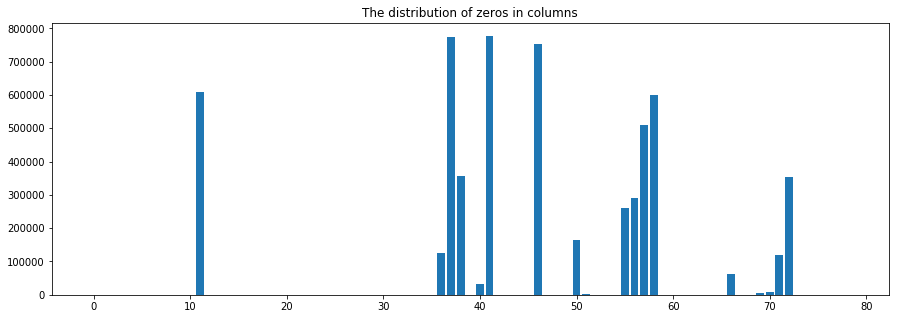

In [36]:
# count the number of zeros in each column
zero_count_per_col = (azdias == 0).astype(int).sum(axis=0)

# Show the distribution of zeros in each column
zero_count_per_col_val = zero_count_per_col.values
plt.figure(figsize=(15,5))
x = np.arange(len(zero_count_per_col_val))
plt.bar(x, zero_count_per_col_val)
plt.title('The distribution of zeros in columns')
plt.show()

In [37]:
# use interquartiles to detect outliers
_ = get_iqr_upper_bound(zero_count_per_col_val)

q1:  0.0  q3:  0.0  iqr:  0.0
Number of outliers:  19
upper_bound:  0.0
min outlier value:  58


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [38]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Create two new columns
azdias['PRAEGENDE_JUGENDJAHRE_GEN'] = azdias['PRAEGENDE_JUGENDJAHRE'].values
azdias['PRAEGENDE_JUGENDJAHRE_MOV'] = azdias['PRAEGENDE_JUGENDJAHRE'].values

# Populate the new columns
attrib_dict_gen = {1:40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 
                   11: 80, 12: 80, 13: 80, 14: 90, 15: 90}

# 0: Mainstream
# 1: Avantgarde
attrib_dict_mov = {1:0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 
                   11: 1, 12: 0, 13: 1, 14: 0, 15: 1}
azdias['PRAEGENDE_JUGENDJAHRE_GEN'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(
                                                        lambda x: attrib_dict_gen[x] if pd.notnull(x) else x)
azdias['PRAEGENDE_JUGENDJAHRE_MOV'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(
                                                        lambda x: attrib_dict_mov[x] if pd.notnull(x) else x)
# Drop the "PRAEGENDE_JUGENDJAHRE" column
azdias = azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

In [39]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Create two new columns
azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'].values
azdias['CAMEO_INTL_2015_STAGE'] = azdias['CAMEO_INTL_2015'].values

# Populate the new columns
attrib_dict_gen = {1:40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 
                   11: 80, 12: 80, 13: 80, 14: 90, 15: 90}

# 0: Mainstream
# 1: Avantgarde
attrib_dict_mov = {1:0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 
                   11: 1, 12: 0, 13: 1, 14: 0, 15: 1}
azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'].apply(lambda x: x[0] if pd.notnull(x) else x)
azdias['CAMEO_INTL_2015_STAGE'] = azdias['CAMEO_INTL_2015'].apply(lambda x: x[1] if pd.notnull(x) else x)

# Drop the "CAMEO_INTL_2015" column
azdias = azdias.drop('CAMEO_INTL_2015', axis=1)

In [40]:
azdias.shape

(780153, 81)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

The mixed-type features in the dataset are LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, PRAEGENDE_JUGENDJAHRE, WOHNLAGE,
CAMEO_INTL_2015, and PLZ8_BAUMAX.

The dropped mixed-type features are the PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015. Each dropped feature was replaced by two features decomposing the mixed-type features.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [41]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Get one hot encoding of categorical and remaining mixed-type features
cat_col_list = ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
                'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP',
                'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015',
                'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']

azdias[cat_col_list] = azdias[cat_col_list].astype(object)

one_hot_cols = pd.get_dummies(azdias[cat_col_list])

# Drop encoded columns
azdias = azdias.drop(cat_col_list,axis = 1)

# Join the encoded columns to dataframe
azdias = azdias.join(one_hot_cols)

In [42]:
azdias.shape

(780153, 258)

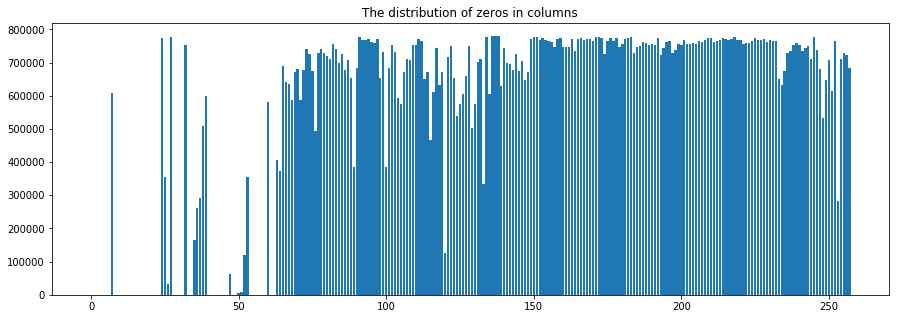

In [43]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# count the number of zeros in each column
zero_count_per_col = (azdias == 0).astype(int).sum(axis=0)

# Show the distribution of zeros in each column
zero_count_per_col_val = zero_count_per_col.values
plt.figure(figsize=(15,5))
x = np.arange(len(zero_count_per_col_val))
plt.bar(x, zero_count_per_col_val)
plt.title('The distribution of zeros in columns')
plt.show()

In [44]:
# use interquartiles to detect outliers
_ = get_iqr_upper_bound(zero_count_per_col_val)

q1:  495777.75  q3:  763589.5  iqr:  267811.75
Number of outliers:  0
upper_bound:  1165307.125


In [45]:
# Select columns to drop, having zeros above threshold, 67% of a column
# The rationale is eliminate the categorical variables with more than 3 categories, assuming a non-biased categorisation. 
col_list_drop = show_cols_to_drop(azdias, zero_count_per_col_val, 498000)

Number of columns to drop:  193


In [46]:
# Remove the zero outlier columns from the dataset.
azdias = azdias.drop(col_list_drop, axis = 1)

In [47]:
azdias.shape

(780153, 65)

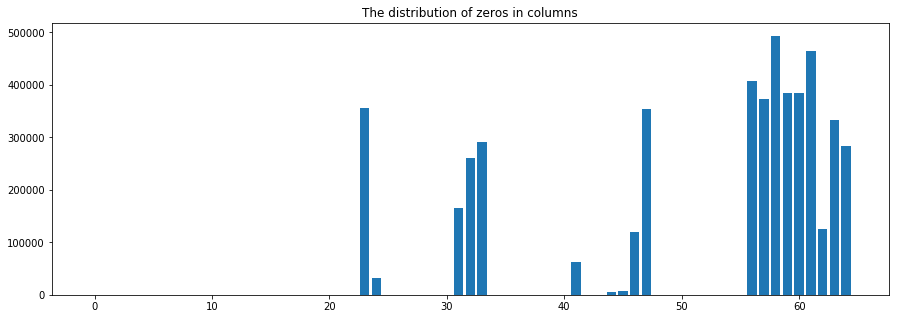

In [48]:
# count the number of zeros in each column
zero_count_per_col = (azdias == 0).astype(int).sum(axis=0)

# Show the distribution of zeros in each column
zero_count_per_col_val = zero_count_per_col.values
plt.figure(figsize=(15,5))
x = np.arange(len(zero_count_per_col_val))
plt.bar(x, zero_count_per_col_val)
plt.title('The distribution of zeros in columns')
plt.show()

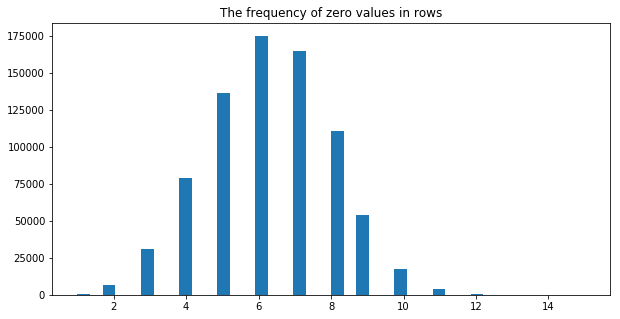

In [49]:
# count the number of zeros in each row
zero_count_per_row = (azdias == 0).astype(int).sum(axis=1)

plt.figure(figsize=(10,5))
plt.hist(zero_count_per_row.values, bins=40)
plt.title('The frequency of zero values in rows')
plt.show()

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [50]:
def clean_data(df, col_list_drop_vis, col_list_drop):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info_values = feat_info.values

    for i in range(feat_info_values.shape[0]):

        attribute = feat_info_values[i,0]
        missing_or_unknown = feat_info_values[i,3]

        if 'XX' in missing_or_unknown:
            missing_or_unknown = missing_or_unknown.replace("XX", "'XX'")
        elif 'X' in missing_or_unknown:
            missing_or_unknown = missing_or_unknown.replace("X", "'X'")

        m_or_unk_list = ast.literal_eval(missing_or_unknown)
        mask = df[attribute].isin(m_or_unk_list)
        df.loc[mask, attribute] = df.loc[mask, attribute].apply(lambda x: np.nan)
    
    
    # remove selected columns and rows, ...
    nan_count_per_col = df.isnull().sum(axis = 0)
    nan_count_per_col_val = nan_count_per_col.values

    
    # Remove the outlier columns from the dataset.
    df = df.drop(col_list_drop_vis, axis = 1)
    
    # get the number of missing data in each row of the dataset
    null_count_per_row = df.isnull().sum(axis=1)
    null_count_per_row_val = null_count_per_row.values
    
    
    upper_bound = get_iqr_upper_bound(null_count_per_row_val)
    
    # divide the data into two subsets based on the number of missing
    # values in each row.
    mask = null_count_per_row <= upper_bound
    df = df.loc[mask]
    
    # Re-encode OST_WEST_KZ to binary categorical feature with numerical values.
    val_dict = {'O':0, 'W':1} 
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].apply(lambda x: val_dict[x] if pd.notnull(x) else x)

    # For consistency, re-encode VERS_TYP to binary categorical feature with 0s and 1s.
    val_dict = {1:0, 2:1}
    df['VERS_TYP'] = df['VERS_TYP'].apply(lambda x: val_dict[x] if pd.notnull(x) else x)
    
    # select, re-encode, and engineer column values.
    # engineer "PRAEGENDE_JUGENDJAHRE" to two new variables.
    # Create two new columns
    df['PRAEGENDE_JUGENDJAHRE_GEN'] = df['PRAEGENDE_JUGENDJAHRE'].values
    df['PRAEGENDE_JUGENDJAHRE_MOV'] = df['PRAEGENDE_JUGENDJAHRE'].values

    # Populate the new columns
    attrib_dict_gen = {1:40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 
                       11: 80, 12: 80, 13: 80, 14: 90, 15: 90}

    # 0: Mainstream
    # 1: Avantgarde
    attrib_dict_mov = {1:0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 
                       11: 1, 12: 0, 13: 1, 14: 0, 15: 1}
    df['PRAEGENDE_JUGENDJAHRE_GEN'] = df['PRAEGENDE_JUGENDJAHRE'].apply(
                                                            lambda x: attrib_dict_gen[x] if pd.notnull(x) else x)
    df['PRAEGENDE_JUGENDJAHRE_MOV'] = df['PRAEGENDE_JUGENDJAHRE'].apply(
                                                            lambda x: attrib_dict_mov[x] if pd.notnull(x) else x)
    # Drop the "PRAEGENDE_JUGENDJAHRE" column
    df = df.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    
    
    # engineer "CAMEO_INTL_2015" to two new variables.
    # Create two new columns
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].values
    df['CAMEO_INTL_2015_STAGE'] = df['CAMEO_INTL_2015'].values

    # Populate the new columns
    attrib_dict_gen = {1:40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 
                       11: 80, 12: 80, 13: 80, 14: 90, 15: 90}

    # 0: Mainstream
    # 1: Avantgarde
    attrib_dict_mov = {1:0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 
                       11: 1, 12: 0, 13: 1, 14: 0, 15: 1}
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: x[0] if pd.notnull(x) else x)
    df['CAMEO_INTL_2015_STAGE'] = df['CAMEO_INTL_2015'].apply(lambda x: x[1] if pd.notnull(x) else x)

    # Drop the "CAMEO_INTL_2015" column
    df = df.drop('CAMEO_INTL_2015', axis=1)
    
    # Get one hot encoding of categorical and mixed-type features
    cat_col_list = ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
                'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP',
                'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015',
                'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']
    df[cat_col_list] = df[cat_col_list].astype(object)
    one_hot_col = pd.get_dummies(df[cat_col_list])
    
    # Drop encoded columns
    df = df.drop(cat_col_list,axis = 1)

    # Join the encoded columns to dataframe
    df = df.join(one_hot_col)
    
    # Delete only available columns
    df_col_list = df.columns
    drop_list = []
    for i in range(len(col_list_drop)):
        for j in range(len(df_col_list)):
            if col_list_drop[i] == df_col_list[j]:
                break
            if j == len(df_col_list)-1:
                drop_list.append(i)
    
    # Delete indices not in df
    for i in range(len(drop_list)):
        del col_list_drop[drop_list[i]]        
    
    # Remove the zero outlier columns from the dataset.
    df = df.drop(col_list_drop, axis = 1)
    
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [51]:
azdias = azdias.apply(pd.to_numeric)

# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias = azdias.fillna(azdias.mean(axis=0))

# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(azdias.values)
azdias = pd.DataFrame(data = scaled_data, columns = azdias.columns)

# Remove outlier rows, with values greater than 3 standard deviations
azdias = azdias[azdias.apply(lambda x: np.abs(x - x.mean()) / x.std() <= 3).all(axis=1)]

azdias.describe()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_INTL_2015_STAGE,ANREDE_KZ_1,ANREDE_KZ_2,FINANZTYP_6,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_GROB_1.0,LP_STATUS_GROB_1.0,NATIONALITAET_KZ_1.0,GEBAEUDETYP_1.0,PLZ8_BAUMAX_1.0
count,714288.000000,714288.000000,714288.000000,714288.000000,714288.000000,714288.000000,714288.000000,714288.000000,714288.000000,714288.000000,...,714288.000000,714288.000000,714288.000000,714288.000000,714288.000000,714288.000000,714288.000000,714288.000000,714288.000000,714288.000000
mean,0.004163,-0.010015,-0.003627,0.006742,-0.008475,-0.010925,0.034715,0.004000,0.003446,0.006830,...,-0.001789,-0.002251,0.002251,0.000783,0.012383,0.012383,0.011510,0.001865,0.005211,-0.011928
std,1.000076,0.999173,1.001614,1.001019,1.001054,0.998299,0.982987,1.000889,1.004060,1.000591,...,1.003841,0.999902,0.999902,1.000215,0.999766,0.999766,1.002199,0.998285,0.999215,1.003338
min,-1.767099,-1.488140,-1.151087,-1.771610,-1.247812,-1.172510,-1.532818,-1.630686,-1.681216,-1.624834,...,-1.260258,-0.958395,-1.043411,-0.762754,-1.012858,-1.012858,-0.822276,-2.275890,-1.159070,-1.326374
25%,-0.784164,-0.762450,-1.151087,-1.045251,-1.247812,-1.172510,-0.817895,-0.276116,-0.992984,-1.110013,...,-1.260258,-0.958395,-1.043411,-0.762754,-1.012858,-1.012858,-0.822276,0.439389,-1.159070,-1.326374
50%,0.198771,-0.036761,0.193996,0.407468,0.109731,-0.454983,-0.102971,-0.276116,0.383479,-0.080370,...,0.087097,-0.958395,0.958395,-0.762754,0.987305,0.987305,-0.822276,0.439389,0.862761,0.753935
75%,1.181706,0.688928,0.866538,1.133828,0.788502,0.980071,0.611953,1.078455,1.071711,0.949272,...,0.760774,1.043411,0.958395,1.311039,0.987305,0.987305,1.216137,0.439389,0.862761,0.753935
max,1.181706,1.414618,1.539080,1.133828,1.467273,1.697599,1.326876,1.078455,1.071711,1.464094,...,1.434452,1.043411,0.958395,1.311039,0.987305,0.987305,1.216137,0.439389,0.862761,0.753935


In [52]:
azdias.shape

(714288, 65)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

To successfully apply feature scaling, the null values in the dataframe were replaced, each with the mean value of the column it belongs. The mean value was chosen as replacement because the scaler employed is the StandardScaler which returns a mean of zero. That is the impact of null values on computation is being minimised. The StandardScaler has the additional advantage of removing excess zero values from the dataset, which makes computation more stable.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained by combining the principal components. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [59]:
# Apply PCA to the data.
scaled_data = azdias.values
X = scaled_data
pca = PCA(random_state=0)
X_pca_gen = pca.fit_transform(X)

In [60]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

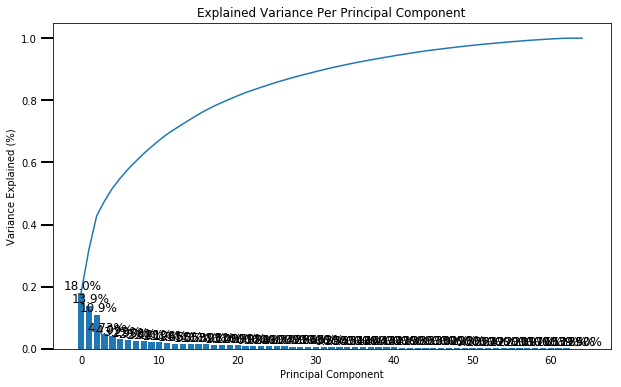

In [61]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [64]:
vals = pca.explained_variance_ratio_
cumvals = np.cumsum(vals)
for i in range(len(cumvals)):
    if cumvals[i] >= 0.80:
        print("Number of components covering 80% variance: ", i+1)
        break

Number of components covering 80% variance:  20


In [65]:
# Re-apply PCA to the data while selecting the number of components to retain.
scaled_data = azdias.values
X = scaled_data
num_components = 20
pca = PCA(num_components, random_state=0)
X_pca_gen = pca.fit_transform(X)

##### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

The standardised dataset has 65 features. 99% of the variance in the dataset can be explained by 57 components. The scree plot levels off after about 57 components. 20 components have been chosen as the preferable number of principal components as it covers 80% of the variability in the dataset. Retaining 80% of the variability reasonably accounts for most variance in the dataset while eliminating noise.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable (element) of the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one is then expected to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [66]:
def pca_results(full_dataset, pca, component_idx):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Component {}'.format(component_idx)]

    # PCA components
    len_pca = len(pca.components_[component_idx])
    pca_comp = pca.components_[component_idx].reshape(1,len_pca)
    components = pd.DataFrame(np.round(pca_comp, 4), columns = full_dataset.keys())
    components.index = dimensions
    
    # sort the features according to weight
    components = components.sort_values(by=dimensions[0], axis=1, ascending=False)
    
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar', legend=False);
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    ev = pca.explained_variance_ratio_[component_idx]
    ax.text(-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n  %.4f"%(ev))

    # Return a concatenated DataFrame
    return  components

,PLZ8_ANTG3,LP_STATUS_GROB_1.0,PLZ8_ANTG4,CAMEO_INTL_2015_WEALTH,ORTSGR_KLS9,EWDICHTE,HH_EINKOMMEN_SCORE,PLZ8_ANTG2,FINANZ_SPARER,FINANZ_HAUSBAUER,...,CAMEO_INTL_2015_STAGE,PLZ8_GBZ,INNENSTADT,KONSUMNAEHE,KBA05_GBZ,PLZ8_BAUMAX_1.0,FINANZ_MINIMALIST,KBA05_ANTG1,PLZ8_ANTG1,MOBI_REGIO
Component 0,0.2247,0.2114,0.2101,0.1952,0.1921,0.1911,0.1879,0.1648,0.1511,0.1475,...,-0.1246,-0.1563,-0.1607,-0.1647,-0.2005,-0.2128,-0.2144,-0.2163,-0.2207,-0.2279


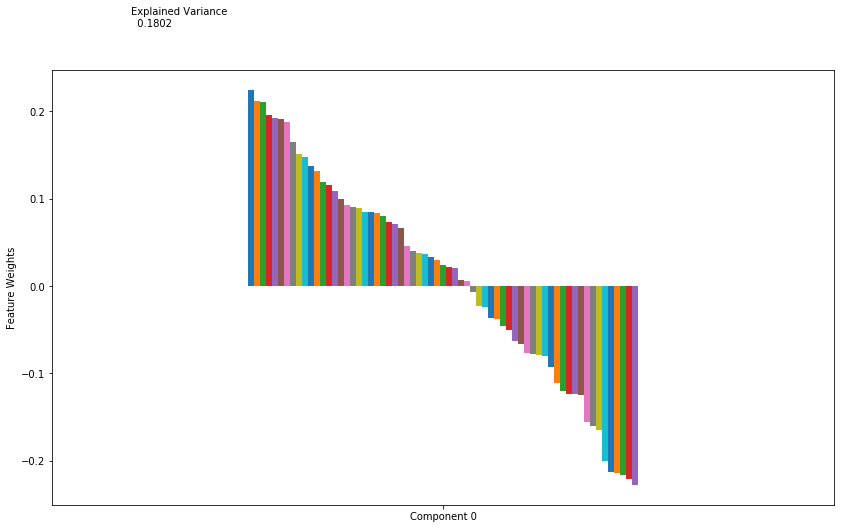

In [67]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
pca_results(azdias, pca, component_idx=0)

,SEMIO_REL,SEMIO_KULT,PRAEGENDE_JUGENDJAHRE_GEN,FINANZ_SPARER,SEMIO_PFLICHT,SEMIO_TRADV,FINANZ_UNAUFFAELLIGER,SEMIO_FAM,FINANZ_ANLEGER,SEMIO_MAT,...,W_KEIT_KIND_HH,FINANZ_HAUSBAUER,ANREDE_KZ_2,SEMIO_KRIT,SEMIO_KAEM,RETOURTYP_BK_S,SEMIO_LUST,FINANZ_VORSORGER,SEMIO_ERL,ALTERSKATEGORIE_GROB
Component 1,0.2556,0.2354,0.2337,0.2184,0.2178,0.2162,0.212,0.1981,0.1828,0.1589,...,-0.111,-0.116,-0.122,-0.1395,-0.141,-0.1534,-0.1686,-0.2153,-0.2388,-0.244


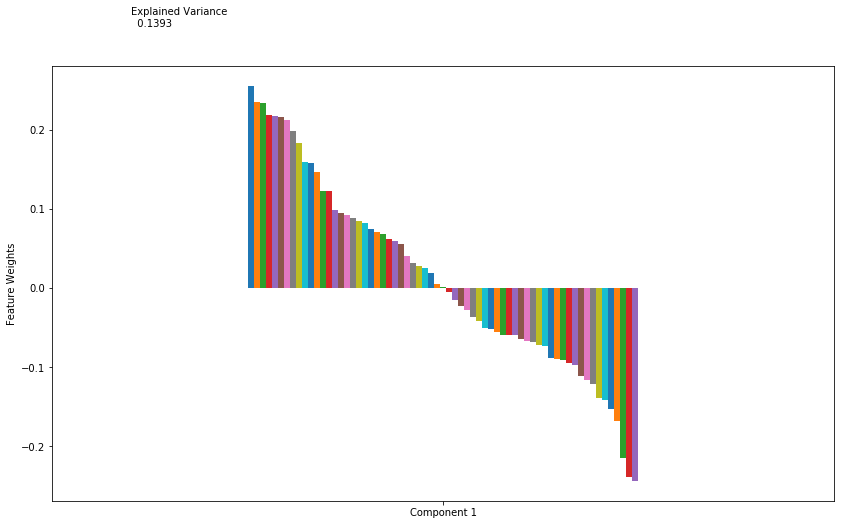

In [68]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(azdias, pca, component_idx=1)

,ANREDE_KZ_1,SEMIO_VERT,SEMIO_SOZ,SEMIO_FAM,SEMIO_KULT,FINANZ_MINIMALIST,RETOURTYP_BK_S,FINANZ_VORSORGER,ALTERSKATEGORIE_GROB,W_KEIT_KIND_HH,...,FINANZ_UNAUFFAELLIGER,FINANZ_SPARER,PRAEGENDE_JUGENDJAHRE_GEN,SEMIO_ERL,FINANZ_ANLEGER,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,ANREDE_KZ_2
Component 2,0.3404,0.3164,0.2329,0.2105,0.1933,0.1523,0.12,0.1162,0.1059,0.1,...,-0.1182,-0.1218,-0.1251,-0.1353,-0.1941,-0.2253,-0.2357,-0.2847,-0.3065,-0.3404


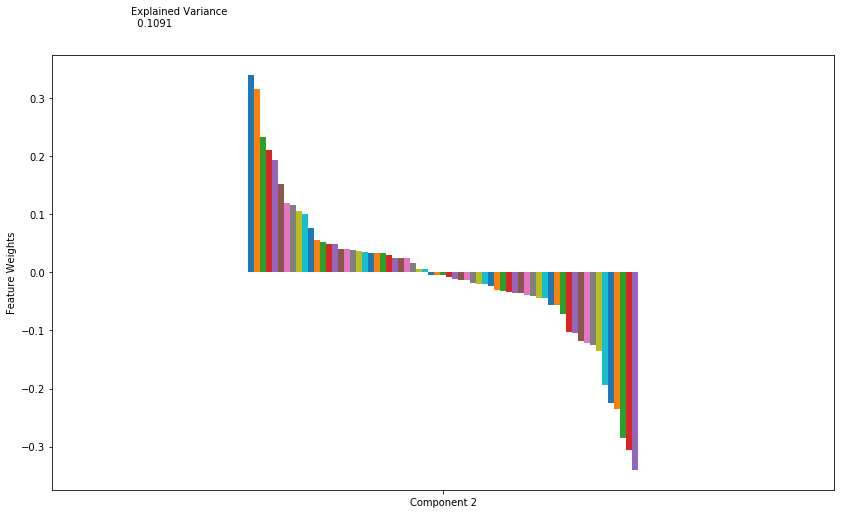

In [69]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(azdias, pca, component_idx=2)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

The first principal component has an explained variance of about 18.0%, the second component has explained variance of 13.9%, while the third component has variance coverage of 10.9%.

The top features the first component correlates to, are PLZ8_ANTG3, LP_STATUS_GROB_1.0, and PLZ8_ANTG4 in the positive direction, and KBA05_GBZ, PLZ8_BAUMAX_1.0, FINANZ_MINIMALIST, KBA05_ANTG1, PLZ8_ANTG1, and MOBI_REGIO in the reverse direction. The first component increases with increase in PLZ8_ANTG3, LP_STATUS_GROB_1.0, and PLZ8_ANTG4, which suggests those features are directly proportional to each other. The first component will also increase with a decrease in the magnitude of KBA05_GBZ, PLZ8_BAUMAX_1.0, FINANZ_MINIMALIST, KBA05_ANTG1, PLZ8_ANTG1, and MOBI_REGIO. It seems the component measures mainly those who score high in PLZ8_ANTG3 and PLZ8_ANTG4 features and low in KBA05_ANTG1 and PLZ8_ANTG1 features, suggesting it measures the size of family houses.

The top features the second component correlates to, are SEMIO_REL, SEMIO_KULT, PRAEGENDE_JUGENDJAHRE_GEN, FINANZ_SPARER, SEMIO_PFLICHT, SEMIO_TRADV, and FINANZ_UNAUFFAELLIGER positively, and FINANZ_VORSORGER, SEMIO_ERL, and ALTERSKATEGORIE_GROB in the reverse direction. The second component increases with increase in SEMIO_REL, SEMIO_KULT, PRAEGENDE_JUGENDJAHRE_GEN, FINANZ_SPARER, SEMIO_PFLICHT, SEMIO_TRADV, and FINANZ_UNAUFFAELLIGER. The second component will also increase with a decrease in the magnitude of FINANZ_VORSORGER, SEMIO_ERL, and ALTERSKATEGORIE_GROB. It seems the component measures the age of the distribution and age related traits.

The top features the third component correlates to, are ANREDE_KZ_1 and SEMIO_VERT positively, as well as to SEMIO_KAEM and ANREDE_KZ_2 negatively. The third component increases with increase in ANREDE_KZ_1 and SEMIO_VERT. The third component will also increase with a decrease in the magnitude of SEMIO_KAEM and ANREDE_KZ_2. It seems the component measures gender and gender traits.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average intra-cluster distance from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [70]:
# Obtain the absolute score for each model
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center, random_state=0)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [83]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
scores = []
centers = list(range(1,20,5))

for center in centers:
    start = int(time.time())
    scores.append(get_kmeans_score(X_pca_gen, center))
    stop = int(time.time())
    time_secs = stop - start
    print("center: ", center, "\t time(s): ", time_secs)

center:  1 	 time(s):  4
center:  6 	 time(s):  57
center:  11 	 time(s):  158
center:  16 	 time(s):  189


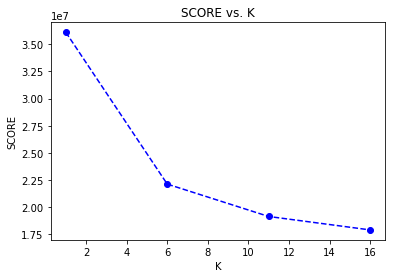

In [84]:
# Investigate the change in intra-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SCORE');
plt.title('SCORE vs. K');

In [71]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=3, random_state=0)

# Then fit the model to your data using the fit method
model = kmeans.fit(X_pca_gen)

# Finally predict the labels on the same data to show the category that point belongs to
labels_gen = model.predict(X_pca_gen)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

The general population dataset was clustered with as many as 51 centroids and yet no clear elbow was seen. It seems similar to the case where there is only a single centroid. The general dataset was finally clustered to three centroids to represent customers with low, medium and high earning potential.

References

Towards Data Science. (2019). The Lonely Cluster. [online] Available at: https://towardsdatascience.com/the-lonely-cluster-6f09abf8a5a4 [Accessed 5 Apr. 2019].

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [72]:
# Load in the general demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=';')

print(customers.shape)

(191652, 85)


In [73]:
# Load in the customer demographics data.
customers = clean_data(customers,col_list_drop_vis, col_list_drop)

q1:  0.0  q3:  34.0  iqr:  34.0
Number of outliers:  0
upper_bound:  85.0


In [74]:
customers.shape

(191652, 65)

In [75]:
# confirm the column labels are same in both datasets
df_col_list = customers.columns
col_list = azdias.columns
drop_list = []
for i in range(len(col_list)):
    for j in range(len(df_col_list)):
        if col_list[i] == df_col_list[j]:
            break
        if j == len(df_col_list)-1:
            print("idx: ", i, "\t col name: ", col_list[i])

In [76]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers = customers.apply(pd.to_numeric)

# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
customers = customers.fillna(customers.mean(axis=0))

# Apply feature scaling to the customer demographics data.
scaled_data = scaler.transform(customers.values)
customers = pd.DataFrame(data = scaled_data, columns = customers.columns)

# Remove outlier rows, with values greater than 3 standard deviations
customers = customers[customers.apply(lambda x: np.abs(x - x.mean()) / x.std() <= 3).all(axis=1)]

# Apply PCA to the data.
scaled_data = customers.values
X = scaled_data
X_pca_cust = pca.transform(X)

# Finally predict the labels on the same data to show the category that point belongs to
labels_cust = model.predict(X_pca_cust)

In [77]:
customers.shape

(151508, 65)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportion in each cluster for the customers. If we think the company's customer base to be universal, then the cluster proportions should be fairly similar between the two. If there is only a particular segment of the population that is interested in the company's products, then we should see a mismatch between the two. If there is a higher proportion of persons in the cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, if the proportion of the data in a cluster is larger for the general population than the customer data (e.g. only 2% of customers closest to the population centroid that captures 6% of the population data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both, for each dataset proportion and to visualize the ratio in cluster representation between the two groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found a group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [78]:
def get_prop_list(hist_vals):
    h_vals, bin_vals = hist_vals[0], hist_vals[1]
    bin_vals = list(bin_vals)
    idx_0 = bin_vals.index(0.)
    idx_1 = bin_vals.index(1.)
    idx_2 = bin_vals.index(2.)
    prop_0 = h_vals[idx_0]/sum(h_vals)
    prop_1 = h_vals[idx_1]/sum(h_vals)
    prop_2 = h_vals[idx_2-1]/sum(h_vals)
    prop_list = [prop_0, prop_1, prop_2]
    return prop_list

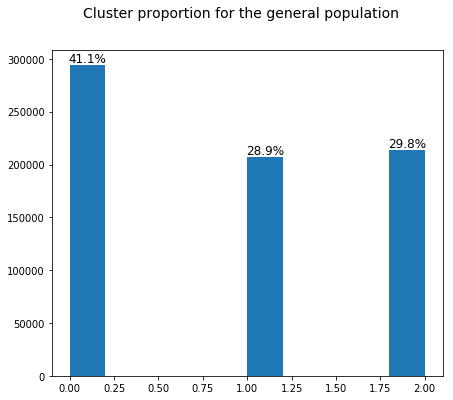

In [79]:
# Compare the proportion of data in each cluster for the customer data and general population data. OR
# Compute the percentage of datapoints in each cluster.


fig = plt.figure(figsize=(7,6))
fig.suptitle('Cluster proportion for the general population', fontsize=14)
ax = plt.subplot(111)
hist_vals = plt.hist(labels_gen)
prop_list = get_prop_list(hist_vals)
h_vals = hist_vals[0]
bin_vals = list(hist_vals[1])
k = 0.1
for i in range(len(prop_list)):
    idx = bin_vals.index(i)
    if i == max(bin_vals):
        idx -= 1
        k = -0.1
    ax.annotate(r"%s%%" % ((str(prop_list[i]*100)[:4])), (i+k, h_vals[idx]), va="bottom", ha="center", fontsize=12)

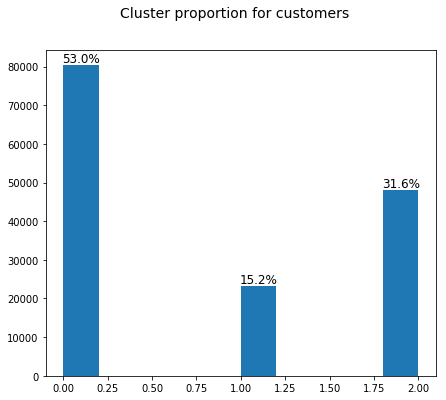

In [80]:
fig = plt.figure(figsize=(7,6))
fig.suptitle('Cluster proportion for customers', fontsize=14)
ax = plt.subplot(111)
hist_vals = plt.hist(labels_cust)
prop_list = get_prop_list(hist_vals)
h_vals = hist_vals[0]
bin_vals = list(hist_vals[1])
k = 0.1
for i in range(len(prop_list)):
    idx = bin_vals.index(i)
    if i == max(bin_vals):
        idx -= 1
        k = -0.1
    ax.annotate(r"%s%%" % ((str(prop_list[i]*100)[:4])), (i+k, h_vals[idx]), va="bottom", ha="center", fontsize=12)

In [81]:
def get_col_sort(df, num_cols):
    # 1- Count
    df = df.append(df.count(), ignore_index=True)
    # 2- sort
    df_sorted = df.sort_values(len(df)-1, axis=1, ascending=False)
    df_sorted = df_sorted.drop(df_sorted.tail(1).index)
    # 3- slice
    df_sorted = df_sorted.iloc[:, :num_cols]
    return df_sorted

def get_row_sort(df, num_row):
    # Get most voting users
    # 1- Count
    df['counts'] = pd.Series(df.count(axis=1))
    # 2- Sort
    df_sorted = df.sort_values('counts', ascending=False)
    # 3- Slice
    df_sorted = df_sorted.iloc[:num_row, :]
    df_sorted = df_sorted.drop(['counts'], axis=1)
    
    return df_sorted

def sort_by_density(df, n_cols, n_rows):
    df_sorted = get_col_sort(df, n_cols)
    df_sorted = get_row_sort(df_sorted, n_rows)
    return df_sorted

def show_clusters(clustered, num_rows, num_cols):
    c=1
    for cluster_id in clustered.group.unique():
        # To improve visibility, we're showing at most num_rows datapoints and num_cols features per cluster.
        d = clustered[clustered.group == cluster_id].drop(['index', 'group'], axis=1)
        n_users_in_cluster = d.shape[0]
        
        d = sort_by_density(d, num_cols, num_rows)
        
        d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
        d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)
        d = d.iloc[:num_rows, :num_cols]
        n_users_in_plot = d.shape[0]
        
        # selecting to show clusters that have more than 9 users, otherwise, they're less interesting
        if len(d) > 9:
            print('cluster # {}'.format(cluster_id))
            print('# of users in cluster: {}.'.format(n_users_in_cluster), '# of users in plot: {}'.format(n_users_in_plot))
            fig = plt.figure(figsize=(15,4))
            ax = plt.gca()

            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = list(d.columns)[:39]

            ax.set_yticks(np.arange(d.shape[0]) , minor=False)
            ax.set_xticks(np.arange(d.shape[1]) , minor=False)

            ax.set_xticklabels(labels, minor=False)
                        
            ax.get_yaxis().set_visible(False)

            # Heatmap
            heatmap = plt.imshow(d, vmin=-3, vmax=3, aspect='auto')

            ax.set_xlabel('components')
            ax.set_ylabel('data-points')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)

            # Color bar
            cbar = fig.colorbar(heatmap, ticks=[3,2,1,0,-1,-2,-3], cax=cax)
            cbar.ax.set_yticklabels(['3', '2','1','0','-1','-2','-3'])

            plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
            plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', labelbottom='off', labelleft='off') 
            

            plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.


cluster # 0
# of users in cluster: 80351. # of users in plot: 70


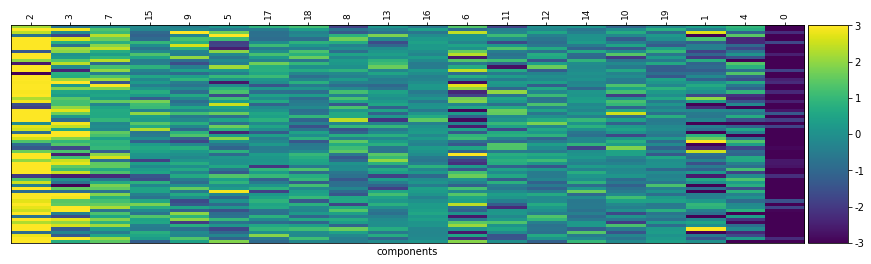

cluster # 1
# of users in cluster: 23144. # of users in plot: 70


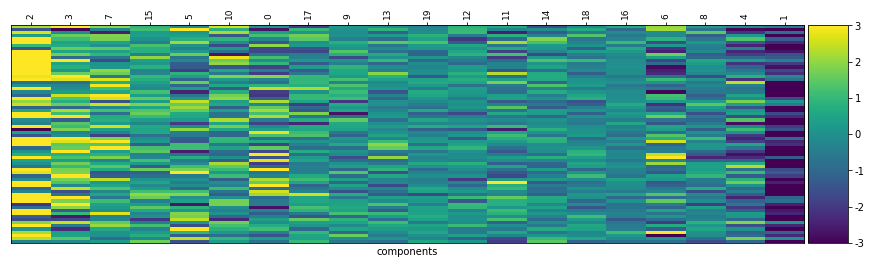

cluster # 2
# of users in cluster: 48013. # of users in plot: 70


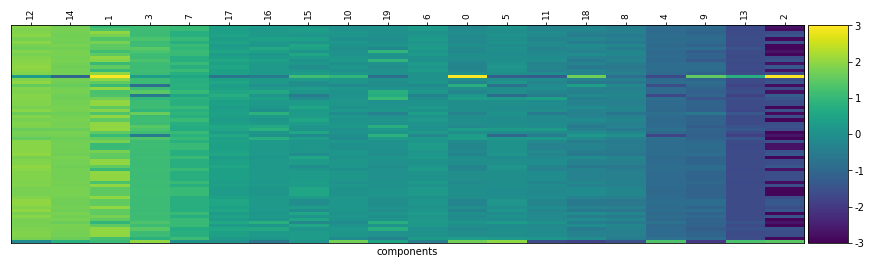

In [82]:
# What type of persons is part of the cluster, overrepresented in the
# customer data compared to the general population?
n_rows = 70
n_cols = 50
X_pca_cust = pd.DataFrame(data=X_pca_cust)
clustered = pd.concat([X_pca_cust.reset_index(), pd.DataFrame({'group':labels_cust})], axis=1)
show_clusters(clustered, n_rows, n_cols)

In [ ]:
## What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

The segment of the population relatively popular with the company is captured by cluster 0. The percentage of datapoints in cluster 0 for the PCA transformed dataset of the customers is 53.0%, while that of the general population is 41.1%. This shows there is a greater representation of cluster 0 datapoints in the company and represents a portion of the population most likely to become customers. With reference to the heatmaps, cluster 0 brings together datapoints with high positive values for component 2, which corresponds to high positive values for ANREDE_KZ_1 and SEMIO_VERT in descending order. Cluster 2 also brings together datapoints with low values of component 0, which corresponds to low values for PLZ8_ANTG3,  LP_STATUS_GROB_1.0, and PLZ8_ANTG4. This cluster seems to be males with middle income.

Conversely, the segment of the population relatively unpopular with the company is the captured by cluster 1. The percentage of datapoints in cluster 1 for the PCA transformed dataset of the customers is 15.2%, while that of the general population is 29.9%. This shows there is a lesser representation of cluster 1 datapoints in the company and represents a portion of the population most unlikely to become customers. With reference to the heatmaps, cluster 1 brings together datapoints with high values of component 2. High values for component 2, corresponds to high values for ANREDE_KZ_1 and SEMIO_VERT. Cluster 1 also brings together datapoints with low values of component 1, which corresponds to low values for SEMIO_REL, SEMIO_KULT, PRAEGENDE_JUGENDJAHRE_GEN, FINANZ_SPARER, SEMIO_PFLICHT, SEMIO_TRADV, and FINANZ_UNAUFFAELLIGER. This cluster seems to be older males.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.